# QRT Stock Prediction

In [419]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [420]:
X_train = pd.read_csv("x_train_Lafd4AH.csv")
Y_train = pd.read_csv("y_train_JQU4vbI.csv")["RET"]   # to not duplicate ID column
train = pd.concat([X_train, Y_train], axis=1)

test = pd.read_csv("x_test_c7ETL4q.csv", index_col='ID')
#print(train.head())
#print(test.head())

print(len(X_train))
print(len(Y_train))
print(len(test))
#btrain.dtypes

418595
418595
198429


# Dataset description
The dataset is made of 46 descriptive features:

- DATE: an index of the date (the dates are randomized and anonymized so there is no continuity or link between any dates),
- STOCK: an index of the stock,
- INDUSTRY: an index of the stock industry domain (e.g., aeronautic, IT, oil company),
- INDUSTRY_GROUP: an index of the group industry,
- SUB_INDUSTRY: a lower level index of the industry,
- SECTOR: an index of the work sector,
- RET_1 to RET_20: the historical residual returns among the last 20 days (i.e., RET_1 is the return of the previous day and so on),
- VOLUME_1 to VOLUME_20: the historical relative volume traded among the last 20 days (i.e., VOLUME_1 is the relative volume of the previous day and so on),

And 1 target variable: (binary)

- RET: the sign of the residual stock return at time t

In [421]:
train.describe()

,ID,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,...,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
count,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,416236.000000,353570.000000,416130.000000,...,413315.000000,351333.000000,413294.000000,356281.000000,413288.000000,351009.000000,413282.000000,351266.000000,413254.000000,350738.000000
mean,209297.000000,108.659002,3373.567833,37.176020,12.697959,5.483845,90.391663,0.001383,-0.071502,0.000973,...,0.001074,-0.076018,0.001642,-0.087854,0.001131,-0.076147,-0.000798,-0.076496,-0.000027,-0.076337
std,120838.112303,61.891642,1533.157749,19.706505,7.231701,2.410113,47.491157,0.031311,3.038658,0.030987,...,0.029538,2.185741,0.031914,2.094459,0.031435,2.423121,0.030738,2.229668,0.033347,2.721355
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.845324,-2.434414,-0.770751,...,-0.765478,-5.600056,-0.825014,-4.610393,-0.876157,-4.167784,-0.880000,-2.341887,-0.785714,-2.768928
25%,104648.500000,56.000000,2478.000000,22.000000,6.000000,4.000000,49.000000,-0.010970,-0.555394,-0.011312,...,-0.010527,-0.533574,-0.011331,-0.552613,-0.010949,-0.539491,-0.012139,-0.527846,-0.011682,-0.542790
50%,209297.000000,104.000000,3560.000000,43.000000,15.000000,6.000000,104.000000,0.000637,-0.282609,0.000401,...,0.000530,-0.272271,0.000433,-0.285480,0.000000,-0.281753,0.000000,-0.277674,0.000000,-0.283405
75%,313945.500000,161.000000,4606.000000,53.000000,19.000000,7.000000,128.000000,0.012950,0.047759,0.012326,...,0.012084,0.029131,0.012862,0.027272,0.012180,0.027639,0.011236,0.030201,0.011712,0.035795
max,418594.000000,223.000000,5716.000000,74.000000,26.000000,11.000000,182.000000,1.444990,1232.174009,1.427746,...,1.028902,355.613431,1.707736,408.771698,6.000004,788.461460,2.954430,631.249564,7.208859,932.939205


## Step 1. Drop noise

The first step is to drop duplicates – that reduced the train dataset by ~2,000 rows. Test dataset had no duplicates.

In [422]:
train.drop_duplicates()
len(train)
#test.drop_duplicates()
#len(test)

418595

In [423]:
col_to_drop = [f'{"RET"}_{day}' for day in range(6, 21)]
col_to_drop += [f'{"VOLUME"}_{day}' for day in range(6, 21)]
train_clean = train.drop(col_to_drop, axis=1)
print(train_clean.head())

   ID  DATE  STOCK  INDUSTRY  INDUSTRY_GROUP  SECTOR  SUB_INDUSTRY     RET_1  \
0   0     0      2        18               5       3            44 -0.015748   
1   1     0      3        43              15       6           104  0.003984   
2   2     0      4        57              20       8           142  0.000440   
3   3     0      8         1               1       1             2  0.031298   
4   4     0     14        36              12       5            92  0.027273   

   VOLUME_1     RET_2  VOLUME_2     RET_3  VOLUME_3     RET_4  VOLUME_4  \
0  0.147931 -0.015504  0.179183  0.010972  0.033832 -0.014672 -0.362868   
1       NaN -0.090580       NaN  0.018826       NaN -0.025540       NaN   
2 -0.096282 -0.058896  0.084771 -0.009042 -0.298777  0.024852 -0.157421   
3 -0.429540  0.007756 -0.089919 -0.004632 -0.639737 -0.019677 -0.940163   
4 -0.847155 -0.039302 -0.943033  0.000000 -1.180629  0.000000 -1.313896   

      RET_5  VOLUME_5    RET  
0  0.016483 -0.972920   True  
1 -0.0

We drop RET and VOLUME past day 5 to reduce noise. 

## Step 2. Check dataset balance

In [424]:
train_clean["RET"].value_counts(normalize=True)*100

RET
False    50.107861
True     49.892139
Name: proportion, dtype: float64

Dataset looks well-balanced – no action needed. If it were to be imbalanced, potential solutions would have included:
1) Resampling: oversample minority class or undersample majority class.
2) Tell the model to penalize mistakes on minority class more.

## Step 3. Check distribution and outliers

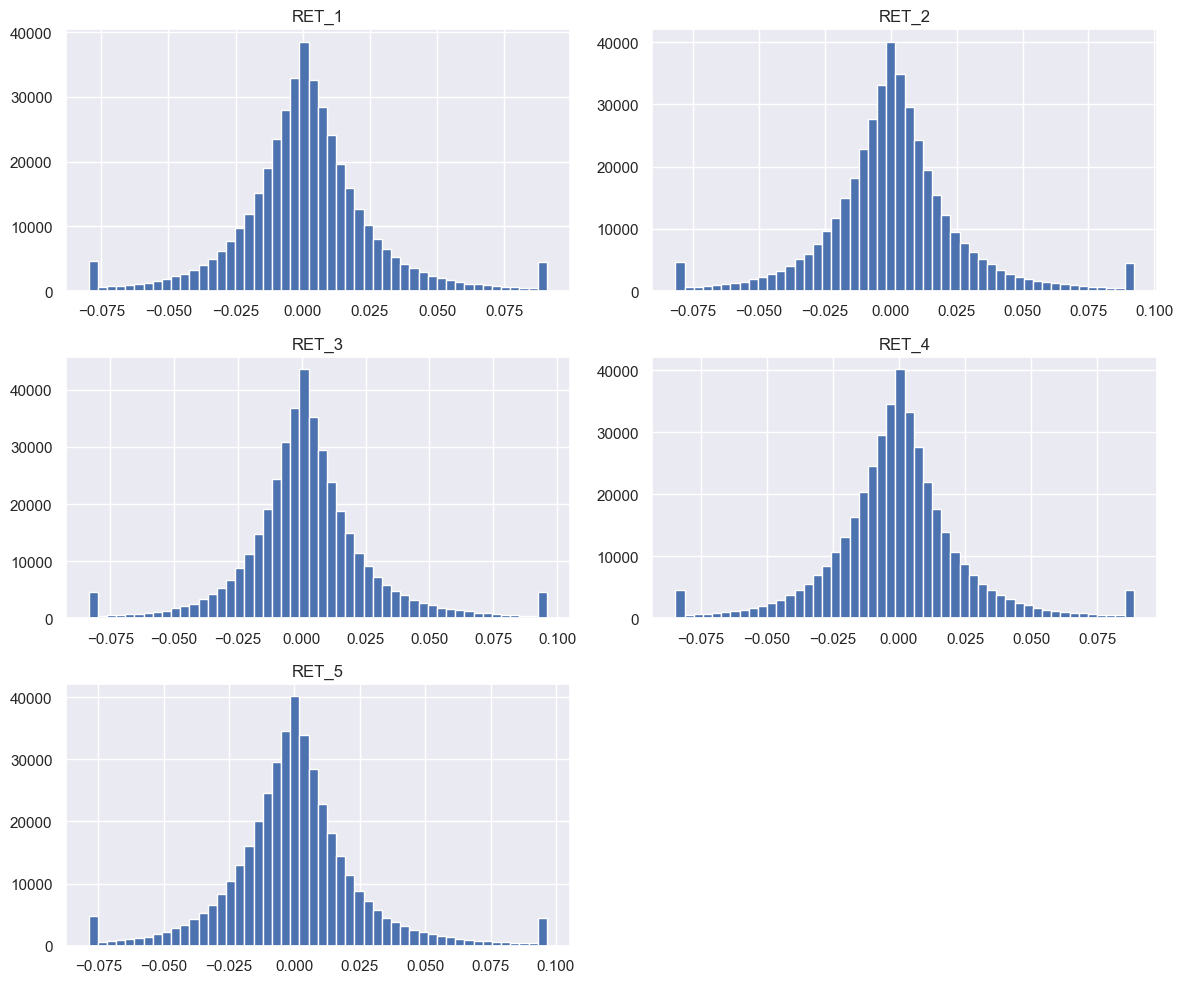

In [425]:
# Winsorize outliers at 1st and 99th percentile
for col in [f'RET_{day}' for day in range(1, 21)]:
    lower = train[col].quantile(0.01)
    upper = train[col].quantile(0.99)
    train[col] = train[col].clip(lower, upper)
    
train[[f'RET_{day}' for day in range(1,6)]].hist(figsize=(12,10), bins=50)
plt.tight_layout()
plt.show()

The distributions look like typical return distributions: clean, symmetric, centered at 0, reasonable range (-8% to +10%), and no extreme outliers. No action needed.

## Step 3. Check correlation

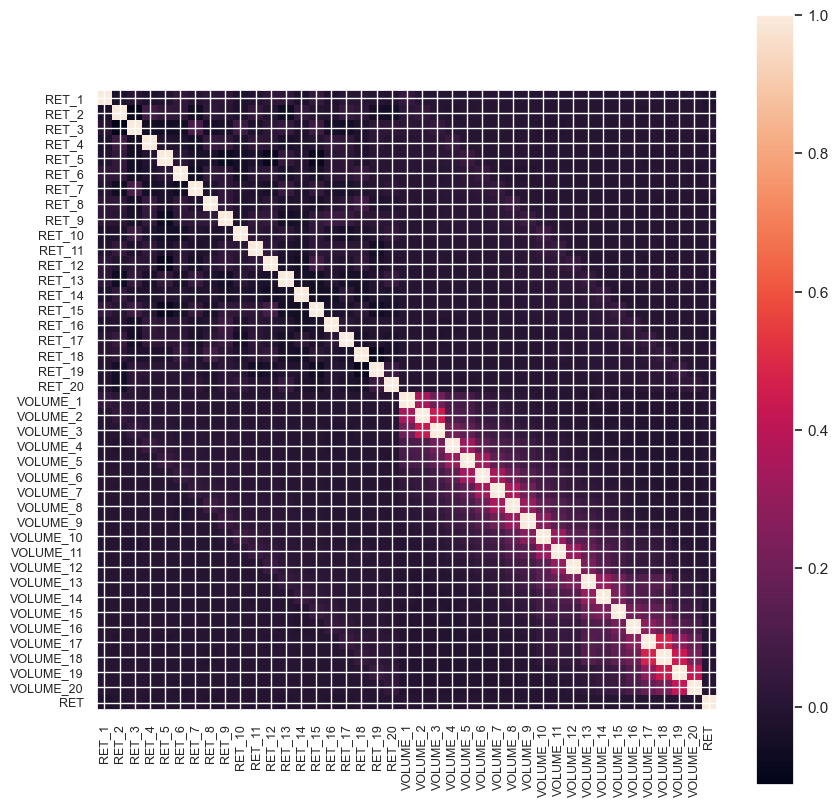

In [426]:
features = [f'RET_{day}' for day in range(1,21)]
features += [f'VOLUME_{day}' for day in range(1,21)]
features += ['RET']

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(train[features].corr())
ax.set_xticks(range(len(features)))
ax.set_yticks(range(len(features)))
ax.set_xticklabels(features, rotation=90, fontsize=9)
ax.set_yticklabels(features, fontsize=9)
plt.colorbar(im)
plt.show()

The features appear uncorrelated with no outliers or surprising values. We can move on to examining missing values.
If features were highly correlated, potential solutions would include:

1) Drop one of the pairwise-correlated features
2) Use PCA to create uncorrelated components
3) Use regularization (L1/L2) to let the model handle it

## Step 4. Missing values 

In [427]:
train_clean.isna().sum() / len(train_clean) * 100

ID                 0.000000
DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.563552
VOLUME_1          15.534108
RET_2              0.588875
VOLUME_2          15.859243
RET_3              0.598908
VOLUME_3          16.201579
RET_4              0.607747
VOLUME_4          16.960785
RET_5              0.617303
VOLUME_5          17.843739
RET                0.000000
dtype: float64

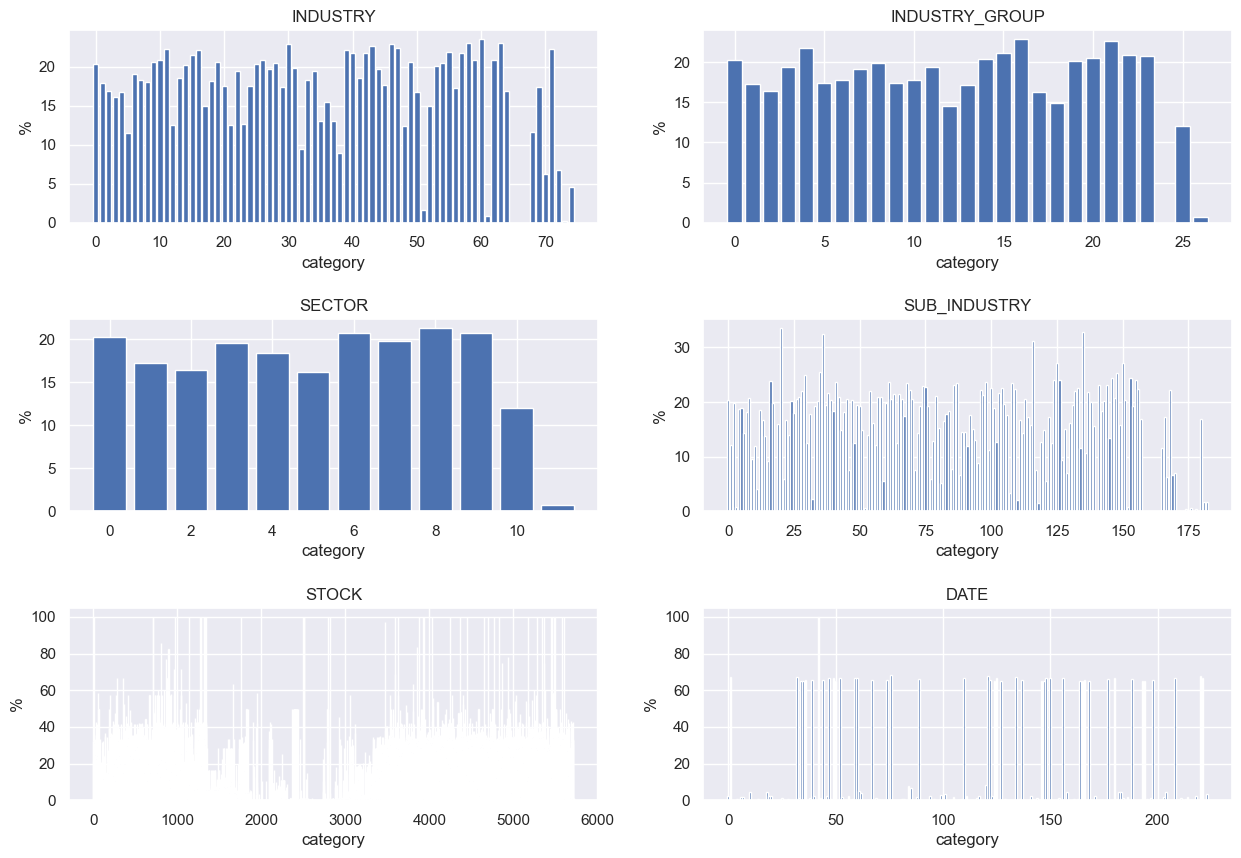

In [428]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
for i, category in enumerate(['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'STOCK', 'DATE']): 
    plt.subplot(3, 2, i+1)
    plt.title(category)
    plt.bar(
        train_clean[category].sort_values().unique(),
        [(train_clean[train_clean[category]==subcategory].isna().sum(axis=1)>0).sum() 
        / 
        len(train_clean[train_clean[category] == subcategory])
        *100 for subcategory in train_clean[category].sort_values().unique()
            ])
    plt.xlabel('category')
    plt.ylabel('%')
plt.show()

Observations: 
INDUSTRY, INDUSTRY_GROUP, SECTOR are fairly flat across categories (homogeneous).
SUB_INDUSTRY looks more heterogeneous; likely due to thin coverage and not structural issues.

Let's first drop stocks that have all values missing for RET – those are useless for prediction.
No need to look at volume in this way since it is either missing or not.

In [429]:
ret_to_drop = train_clean[[f'RET_{day}' for day in range(1,6)]].isna().all(axis=1)
ret_to_drop = ret_to_drop[ret_to_drop==True]
print(ret_to_drop)
print("Proportion:", len(ret_to_drop)/len(train_clean)*100, "%")

2237      True
19916     True
20232     True
27739     True
28578     True
          ... 
401583    True
401584    True
401585    True
401586    True
401590    True
Length: 2256, dtype: bool
Proportion: 0.538945759027222 %


The above have values missing for all the past 5 days meaning they carry no predictive signal. We can confidently drop them. Good news is that they constitute only 0.53% of the total.

In [430]:
train_clean2 = train_clean.drop(ret_to_drop[ret_to_drop].index)
train_clean2.isna().sum() / len(train_clean2) * 100

ID                 0.000000
DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.024739
VOLUME_1          15.076416
RET_2              0.050199
VOLUME_2          15.403313
RET_3              0.060287
VOLUME_3          15.747504
RET_4              0.069174
VOLUME_4          16.510824
RET_5              0.078782
VOLUME_5          17.398562
RET                0.000000
dtype: float64

We reduced the number of missing values in RET columns quite well compared with the prior missing-values output. This means that dropped rows were extremely NaN-dense.

In [431]:
volume = pd.DataFrame(columns=['day', 'ret_mean', 'ret_median', 'ret_std', 'vol_mean', 'vol_median', 'vol_std'])
for day in range(1,6):
    volume.loc[day] =[day, train_clean2[f'RET_{day}'].mean(), train_clean2[f'RET_{day}'].median(), train_clean2[f'RET_{day}'].std(), 
                      train_clean2[f'VOLUME_{day}'].mean(), train_clean2[f'VOLUME_{day}'].median(), train_clean2[f'VOLUME_{day}'].std()]
volume

,day,ret_mean,ret_median,ret_std,vol_mean,vol_median,vol_std
1,1.0,0.001383,0.000637,0.031311,-0.071502,-0.282609,3.038658
2,2.0,0.000973,0.000401,0.030987,-0.075230,-0.278437,2.635549
3,3.0,0.002153,0.000909,0.031332,-0.097235,-0.278277,2.490831
4,4.0,-0.000679,-0.000495,0.031224,-0.088976,-0.275435,1.730786
5,5.0,0.000358,0.000000,0.031886,-0.092163,-0.281238,1.848977


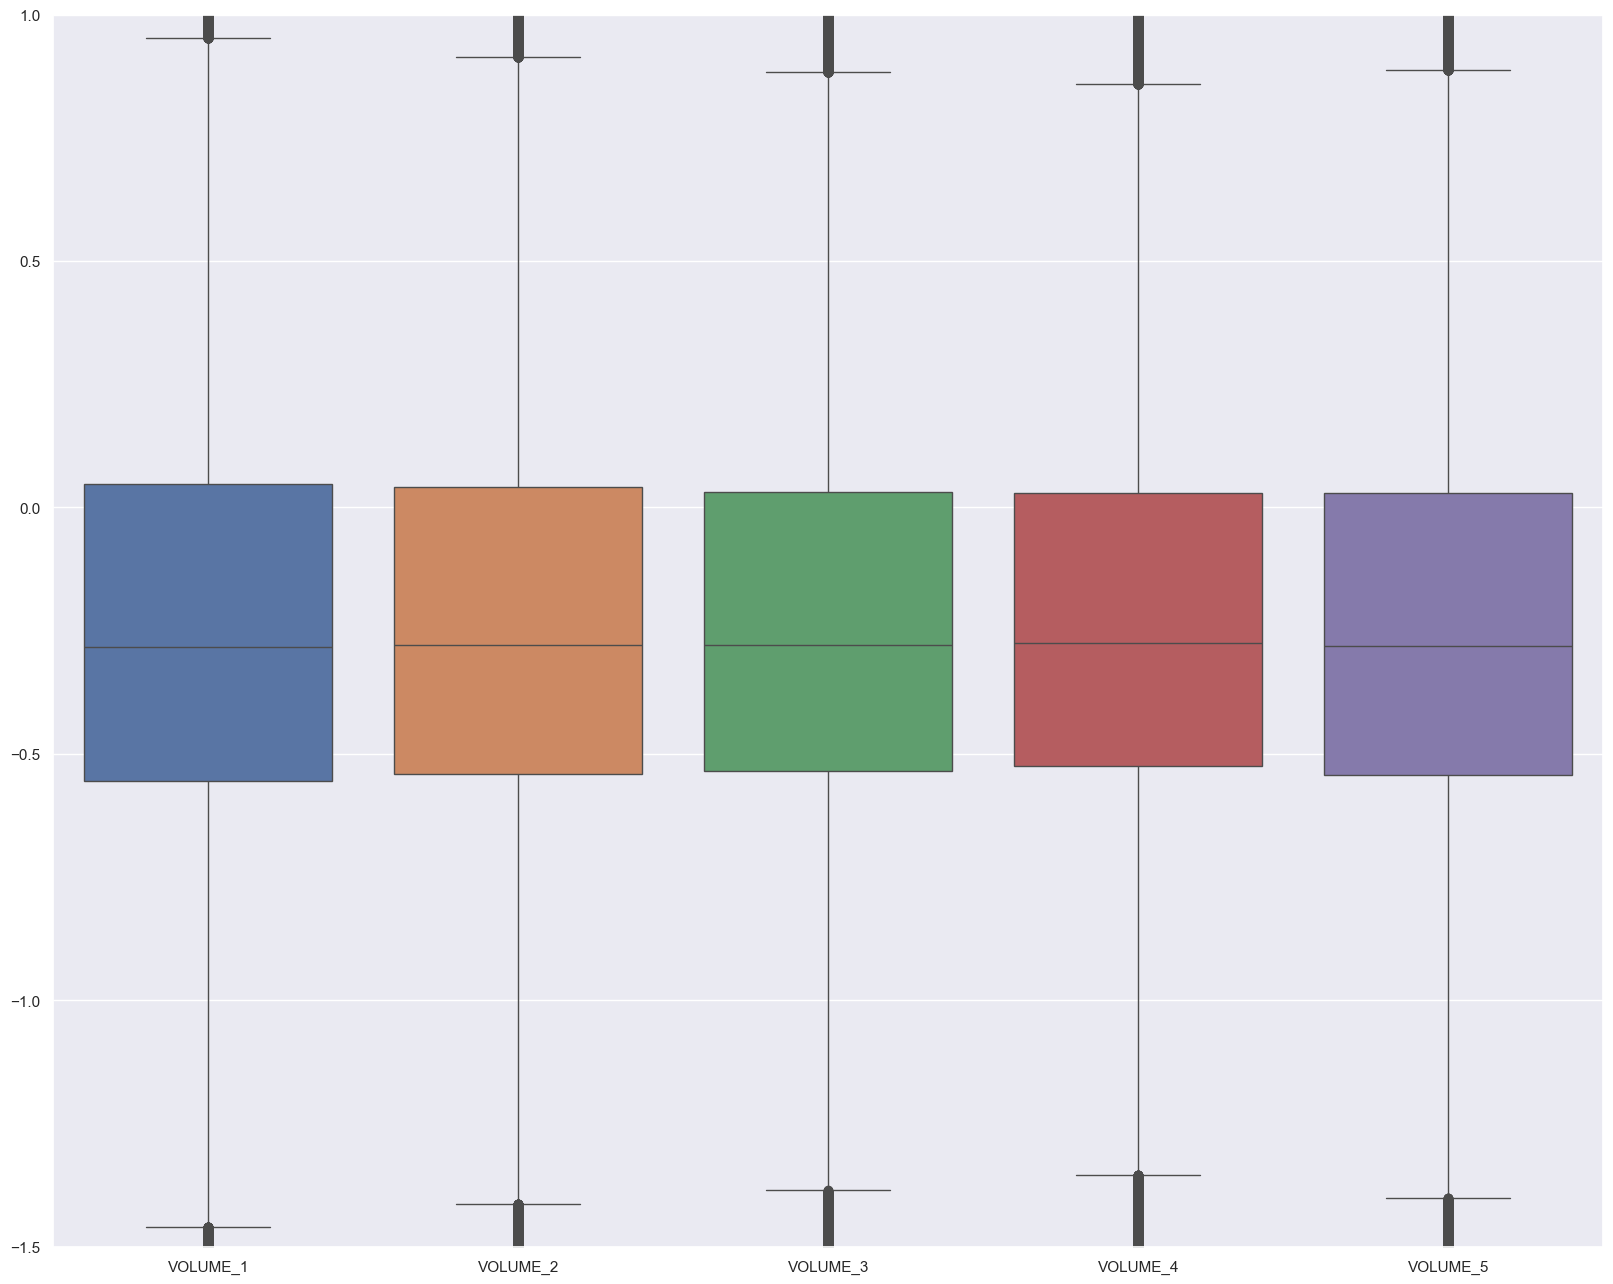

In [432]:
sns.boxplot(train_clean2[[f'VOLUME_{day}' for day in range(1,6)]])
plt.ylim((-1.5, 1))
plt.show()

0.048828986678076745


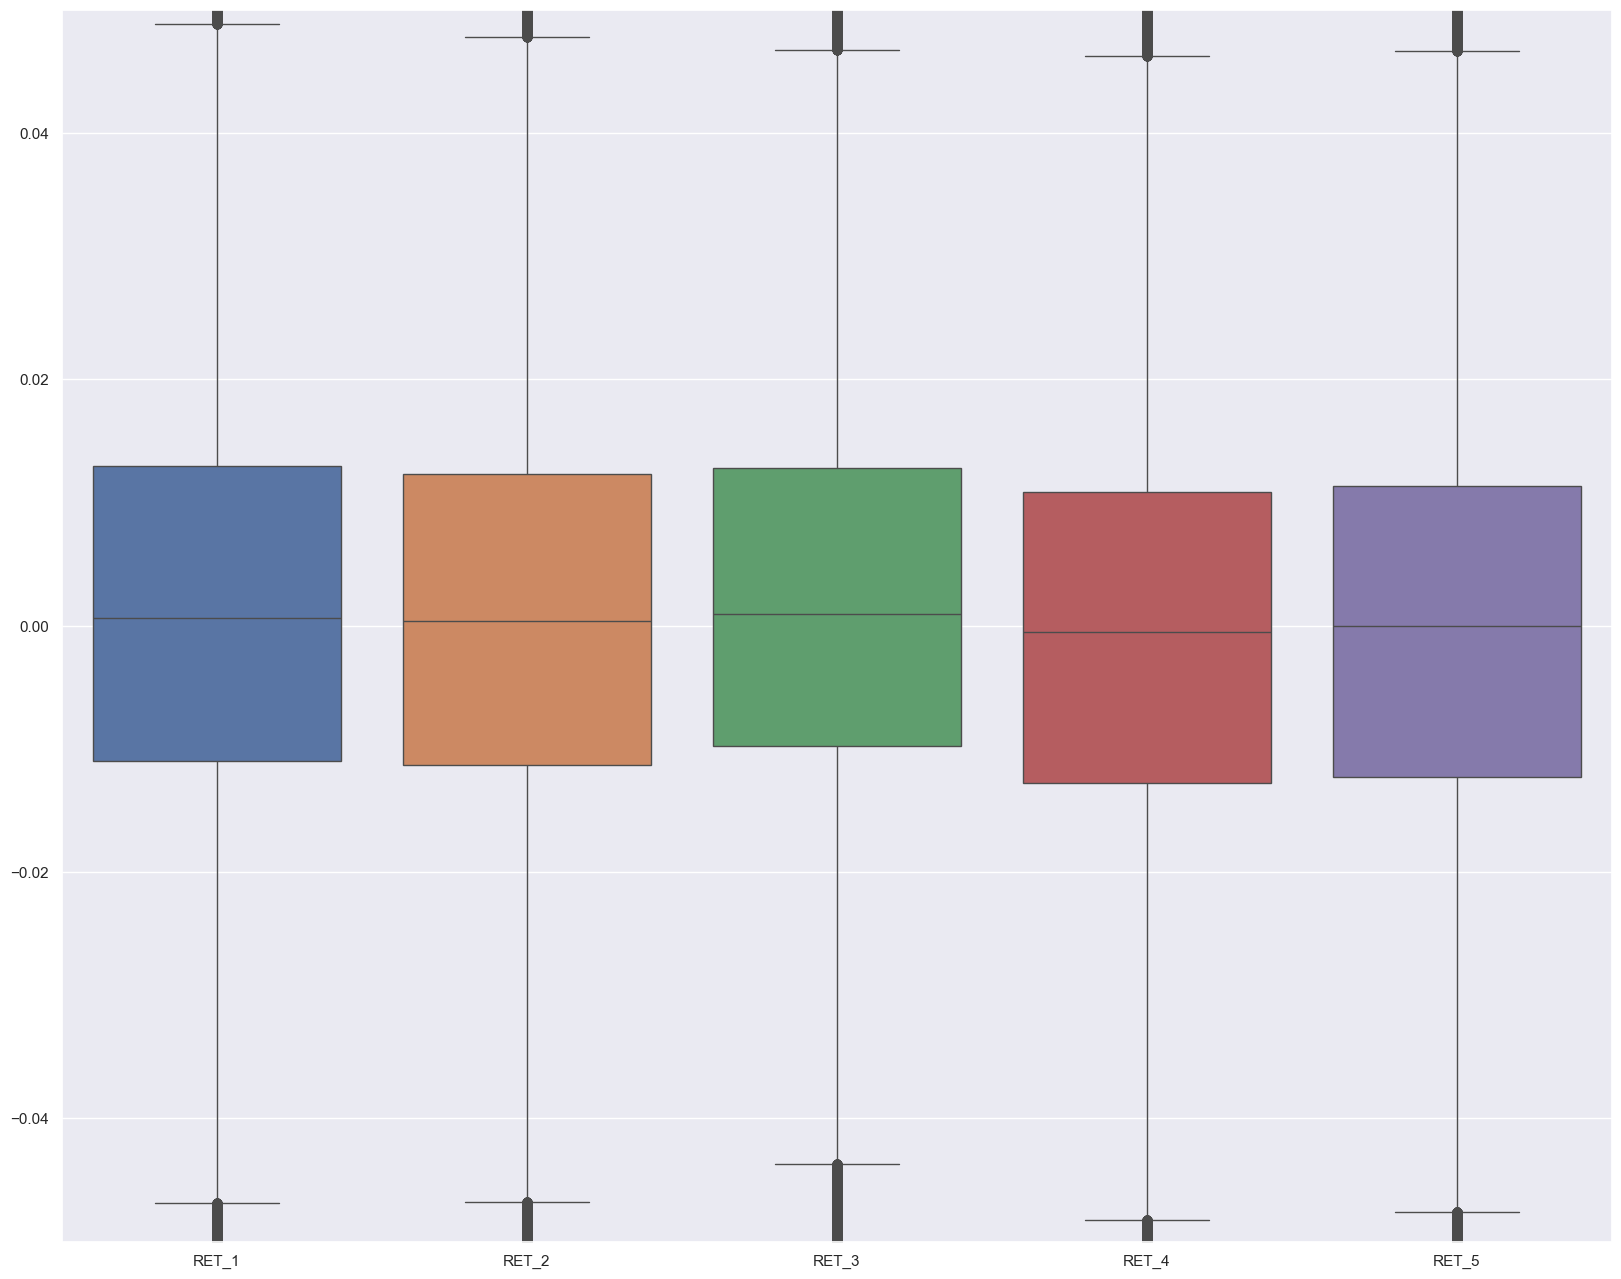

In [433]:
# Finding proper outliers for plt.ylim
Q3 = train_clean2["RET_1"].quantile(0.75)
Q1 = train_clean2["RET_1"].quantile(0.25)
IQR = Q3 - Q1
outlier_up = Q3 + 1.5*IQR
print(outlier_up)

sns.boxplot(train_clean2[[f'RET_{day}' for day in range(1,6)]])
plt.ylim((-0.05, 0.05))
plt.show()

## Step 5. Dataset Imputation

Notice that while mean vs. median imputation would not make much difference for RET values, mean imputation may be too optimisitc for VOLUME. We thus use median imputation on both for convenience. But first let's drop rows where RET value is missing for every of the recent 5 days.

In [434]:
ret_features = [f'{"RET"}_{day}' for day in range(1,6)]
train = train[(train[ret_features].isna().sum(axis=1) / (train[ret_features].shape[1]) < 1)]

In [435]:
for column in [f'VOLUME_{day}' for day in range(1,21)]:
    train[column] = train[column].fillna(train[column].median())
    test[column] = test[column].fillna(test[column].median())

In [436]:
for column in [f'RET_{day}' for day in range(1,21)]:
    train[column] = train[column].fillna(train[column].median())
    test[column] = test[column].fillna(test[column].median())

## Step 6. Feature engineering

In [437]:
new_features = []

In [438]:
# Nested loops
shifts = [1,2,3,4]
statistics = ['mean']
gb_feat_list = [['SECTOR', 'DATE']]
target_feat = ['RET']

for target in target_feat:
        for gb_feat in gb_feat_list:
            temp_name = '_'.join(gb_feat)
            for shift in shifts:
                for stat in statistics:
                    name = f'{target}_{shift}_{temp_name}_{stat}'
                    feature = f'{target}_{shift}'
                    new_features.append(name)
                    for data in [train, test]:
                        data[name] = data.groupby(gb_feat)[feature].transform(stat)
#train.head()

In [439]:
weeks = 4
statistics = ['mean', 'std'] #min, max, median
gb_feat_list = [['STOCK', 'DATE']]
target_feat = ['RET', 'VOLUME']

for target in target_feat:
     for gb_feat in gb_feat_list:
            temp_name = '_'.join(gb_feat)
            for stat in statistics:
                for week in range(weeks):
                    name = f'{stat}_{target}_STOCK_WEEK_{week+1}'
                    new_features.append(name)
                    for data in [train, test]:
                        if stat == "mean":
                            if target == "VOLUME":                                                   # absolute value for volume
                                data[name] = data[[f'{target}_{week*5 + day}' for day in range(1,6)]].mean(axis=1).abs()
                            else:
                                data[name] = data[[f'{target}_{week*5 + day}' for day in range(1,6)]].mean(axis=1)
                        elif stat == "std":
                            data[name] = data[[f'{target}_{week*5 + day}' for day in range(1,6)]].std(axis=1)
                        elif stat == "min":
                            data[name] = data[[f'{target}_{week*5 + day}' for day in range(1,6)]].min(axis=1)
                        elif stat == "max":
                            data[name] = data[[f'{target}_{week*5 + day}' for day in range(1,6)]].max(axis=1)
                        elif stat == "median":
                            data[name] = data[[f'{target}_{week*5 + day}' for day in range(1,6)]].median(axis=1)

In [440]:
# Relative measure of stock's VOLUME compared to its sector
shifts = [1,2,3,4] 
statistics = ['sum']
gb_feat_list = [['SECTOR', 'DATE']]
target_features = ['mean_VOLUME_STOCK_WEEK']

for target in target_features:
    for gb_feat in gb_feat_list:
        temp_name = "_".join(gb_feat)
        for shift in shifts:
            for stat in statistics:
                name = f'{target}_{shift}_/total_VOLUME_of_SECTOR_DATE'
                feat = f'{target}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data[feat] / data.groupby(gb_feat)[feat].transform(stat)

In [441]:
# Analogous for RET
shifts = [1,2,3,4]
gb_feat_list = ['SECTOR', 'DATE']
statistics = ['sum']
target_features = ['mean_RET_STOCK_WEEK']

for target in target_features:
    for gb_feat in gb_feat_list:
        temp_name = '_'.join(gb_feat)
        for shift in shifts:
            for stat in statistics:
                name = f'{target}_{shift}/total_RET_of_SECTOR_DATE'
                feat = f'{target}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data[feat] / data.groupby(gb_feat)[feat].transform(stat)

We now add a more dynamic feature – residual return momentum. We do so by calculating the average return over day D-1,...,D-10 and subtract it from the return of day D to get an idea where our stock might go. The residual return momentum reflects recent performance trends.

In [442]:
weeks = [2]
target_features = ['RET', 'VOLUME']

for target in target_features:
    for week in weeks:
        name = f'{target}_{week*5}_momentum'
        new_features.append(name)
        for data in [train, test]:
            _data = data.copy()
            momentum = data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_{day}' for day in range(1,week*5)]].mean()
            target_1 = data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_1']].mean()
            momentum_aligned, target_1_aligned = momentum.align(target_1, axis=0, level='SECTOR')
            target_momentum = target_1_aligned.sub(momentum_aligned.mean(axis=1), axis=0)
            target_momentum.rename(columns={f'{target}_1': name}, inplace=True)
            placeholder = _data.join(target_momentum, on=['SECTOR', 'DATE'], how='left')
            data[name] = placeholder[name]

In [456]:
# Residual momentum and weighted momentum
target_features = ['RET']
shifts = [5]

for target in target_features:
    for shift in shifts:
        name = f'{target}_{shift}_residual_momentum'
        new_features.append(name)
        for data in [train, test]:
            cols = [f'{target}_{day}' for day in range(2, shift+1)]
            avg_past = data[cols].mean(axis=1) 
            day_1 = data[f'{target}_1']
            data[name] = day_1 - avg_past

In [457]:
target_features = ['RET']
shifts = [5]

for target in target_features:
    for shift in shifts:
        name = f'{target}_{shift}_weighted_momentum'
        new_features.append(name)
        
        for data in [train, test]:
            # Create weights: most recent gets highest weight
            # For shift=5: weights = [5, 4, 3, 2, 1]
            weights = np.arange(shift, 0, -1)
            weights = weights / weights.sum()  # Normalize to sum to 1
            weighted_sum = 0
            for i, day in enumerate(range(1, shift + 1)):
                weighted_sum += data[f'{target}_{day}'] * weights[i]
            
            data[name] = weighted_sum

Now, compute standard deviation of averages to measure volatility - conditioned on sector

In [445]:
weeks = [2]
targets = ['RET', 'VOLUME']

for week in weeks: 
    window_size = 5*week
    for target in targets: 
        name = f'{window_size}_day_mean_{target}_vola'
        new_features.append(name)
        for data in [train, test]:
            rolling_std_target = data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_{day}' for day in range(1,window_size+1)]].mean().std(axis=1).to_frame(name)
            placeholder = data.join(rolling_std_target, on=['SECTOR', 'DATE'], how='left')
            data[name] = placeholder[name]


Relative strength index per sector. The RSI measures the speed and change of price movements.

In [446]:
targets = ["RET"]
window_size = 20
name = f"RSI_SECTOR_DATE_{window_size}"
new_features.append(name)

for target in targets:
    for data in [train, test]:
        _data = data.copy()
        avg_gain_sector_day = _data.groupby(by=['SECTOR', 'DATE'])[[f'{"RET"}_{day}' for day in range(1, window_size+1)]].mean().agg(lambda x: x[x>0].mean(), axis=1)
        avg_loss_sector_day = _data.groupby(by=['SECTOR', 'DATE'])[[f'{"RET"}_{day}' for day in range(1, window_size+1)]].mean().agg(lambda x: x[x<0].mean(), axis=1).abs()
        rs_sector_day = avg_gain_sector_day/avg_loss_sector_day
        rsi_sector_date = 100 - 100/(1+rs_sector_day)
        placeholder = _data.join(rsi_sector_date.to_frame(name), on=['SECTOR', 'DATE'], how='left')
        data[name] = placeholder[name]


Aggregated advance-decline line indicator conditioned on sector. ADLsum​=∑​Net Advances_i (signal overall market trends)

In [447]:
window_size = 5
name = 'Sum_ADL'
new_features.append(name)
for data in [train, test]:
    _data = data.copy()
    sum_adl = ((_data.groupby(by=["SECTOR", "DATE"])[[f'RET_{day}' for day in range(1, window_size+1)]]).apply(lambda x: (x>0).sum()) - (_data.groupby(by=["SECTOR", "DATE"])[[f'RET_{day}' for day in range(1, window_size+1)]]).apply(lambda x: (x<0).sum())).sum(axis=1)
    placeholder = _data.join(sum_adl.to_frame(name), on=['SECTOR', 'DATE'], how='left')
    data[name] = placeholder[name]


Now compute 3 following features: short-term reversal, volume-return interaction, and cross-sectional reversal (relative to sector).

In [448]:
# Short-term reversal (negative of recent return)
target_features = ['RET']
shifts = [1, 2, 3]

for target in target_features:
    for shift in shifts:
        name = f'{target}_{shift}_reversal'
        new_features.append(name)
        for data in [train, test]:
            data[name] = -data[f'{target}_{shift}']

# Volume-return interaction (volume confirms move)
target_features = ['RET']
shifts = [1, 2, 3]

for target in target_features:
    for shift in shifts:
        name = f'{target}_{shift}_volume_confirmed'
        new_features.append(name)
        for data in [train, test]:
            vol = data[f'VOLUME_{shift}'].clip(lower=0)  # clip negatives to 0
            data[name] = data[f'{target}_{shift}'] * np.log1p(vol)
            
# Cross-sectional reversal (relative to sector)
target_features = ['RET']
shifts = [1, 2]

for target in target_features:
    for shift in shifts:
        name = f'{target}_{shift}_sector_reversal'
        new_features.append(name)
        for data in [train, test]:
            sector_mean = data.groupby(['SECTOR', 'DATE'])[f'{target}_{shift}'].transform('mean')
            data[name] = -(data[f'{target}_{shift}'] - sector_mean)

# Feature selection

In [458]:
target = 'RET'

n_shifts_ret = 5  # recent 5 to reduce noise
n_shifts_vol = 5
features = ['RET_%d' % (i + 1) for i in range(n_shifts_ret)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts_vol)]
features += new_features  # conditional features
train[features].head()


,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,...,RET_1_reversal,RET_2_reversal,RET_3_reversal,RET_1_volume_confirmed,RET_2_volume_confirmed,RET_3_volume_confirmed,RET_1_sector_reversal,RET_2_sector_reversal,RET_5_residual_momentum,RET_5_weighted_momentum
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920,...,0.015748,0.015504,-0.010972,-0.002173,-0.002555,0.000365,0.024756,-0.001772,-0.015068,-0.008047
1,0.003984,-0.081571,0.018826,-0.025540,-0.038062,-0.282609,-0.278437,-0.278277,-0.275435,-0.281238,...,-0.003984,0.081571,-0.018826,0.000000,-0.000000,0.000000,0.001838,0.059677,0.035571,-0.022602
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455,...,-0.000440,0.058896,0.009042,0.000000,-0.004792,-0.000000,0.011293,0.017262,0.008873,-0.013430
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464,...,-0.031298,-0.007756,0.004632,0.000000,0.000000,-0.000000,-0.014045,-0.006451,0.034551,0.009187
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398,...,-0.027273,0.039302,-0.000000,0.000000,-0.000000,0.000000,-0.020486,0.025649,0.031518,0.000099


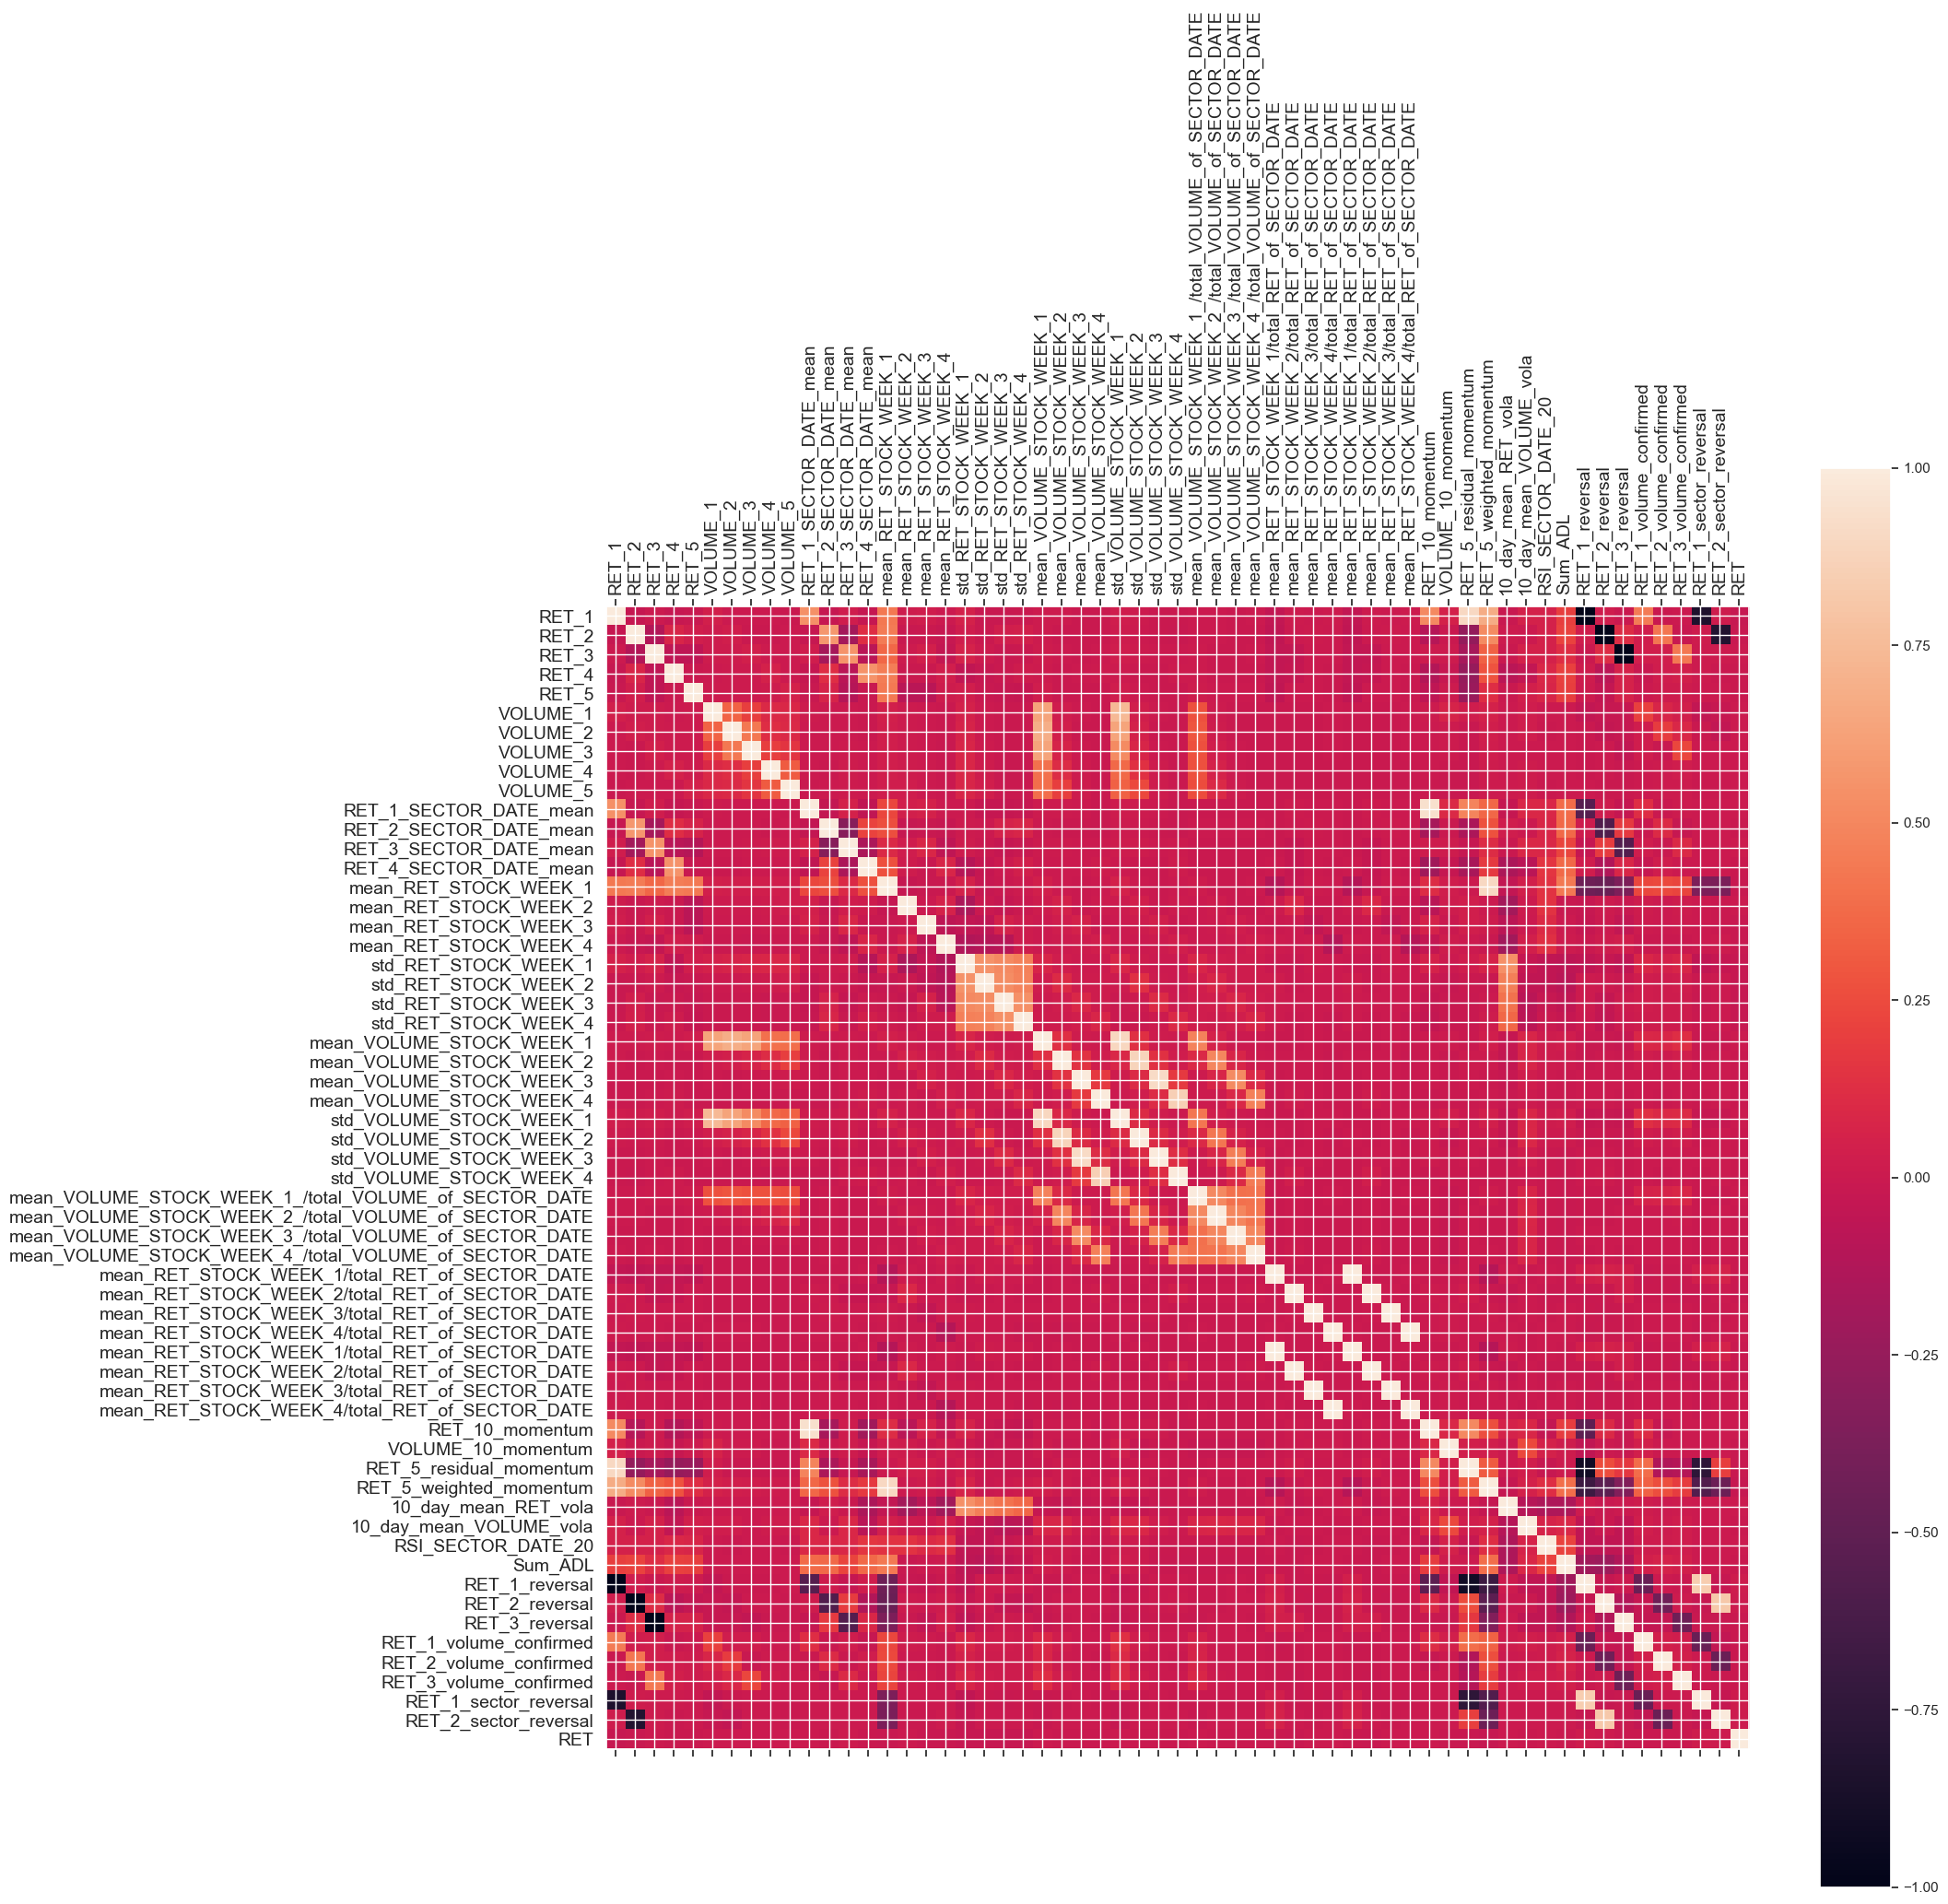

In [450]:
corr_features = features + ['RET']
fig = plt.figure(figsize=(20,20))
plt.matshow(train[corr_features].corr(), fignum=0)
plt.xticks(range(train[corr_features].shape[1]), train[corr_features].columns, rotation=90, fontsize=14)
plt.yticks(range(train[corr_features].shape[1]), train[corr_features].columns, fontsize=14)
plt.colorbar()
plt.show()


# Model Selection and Local Score

Let's look at how well models do. I used the LGBM version of RF to quickly test and identify new promising features. I then looked at feature importance and dropped the ones that don't add much value.

In [451]:
drop_features = [
    # Redundant reversals (tree already sees RET_1, RET_2, etc.)
    'RET_2_reversal', 'RET_3_reversal',
    
    # Volume confirmed not helping
    'RET_2_volume_confirmed', 'RET_3_volume_confirmed',
    
    # Sector reversal lag 2 not helping
    'RET_2_sector_reversal',
    
    # All the bottom volume features
    'VOLUME_2', 'VOLUME_3', 'VOLUME_4', 'VOLUME_5',
    'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 
    'mean_VOLUME_STOCK_WEEK_3', 'mean_VOLUME_STOCK_WEEK_4',
    'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
    'std_VOLUME_STOCK_WEEK_3', 'std_VOLUME_STOCK_WEEK_4',
    'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
    'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE',
    'mean_VOLUME_STOCK_WEEK_3_/total_VOLUME_of_SECTOR_DATE',
    'mean_VOLUME_STOCK_WEEK_4_/total_VOLUME_of_SECTOR_DATE',
]

X_train = X_train.drop(columns=drop_features, errors='ignore')
X_test = X_test.drop(columns=drop_features, errors='ignore')

In [459]:
X_train = train[features]
y_train = train[target]

# LGBM RF (same params as for RandomForestClassifier below) 
parameters = {
    'boosting_type': 'rf',
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1, 
    'feature_fraction': np.log(X_train.shape[0])/X_train.shape[0],
    'objective': 'binary',
    'verbose': -1
}

rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0, shuffle=True).split(train_dates) 
for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    #model = LGBMClassifier(**parameters)
    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train.values.reshape(-1))

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 51.32%
Fold 2 - Accuracy: 51.00%
Fold 3 - Accuracy: 53.08%
Fold 4 - Accuracy: 51.94%
Accuracy: 51.83% [51.04 ; 52.63] (+- 0.79)


<Axes: >

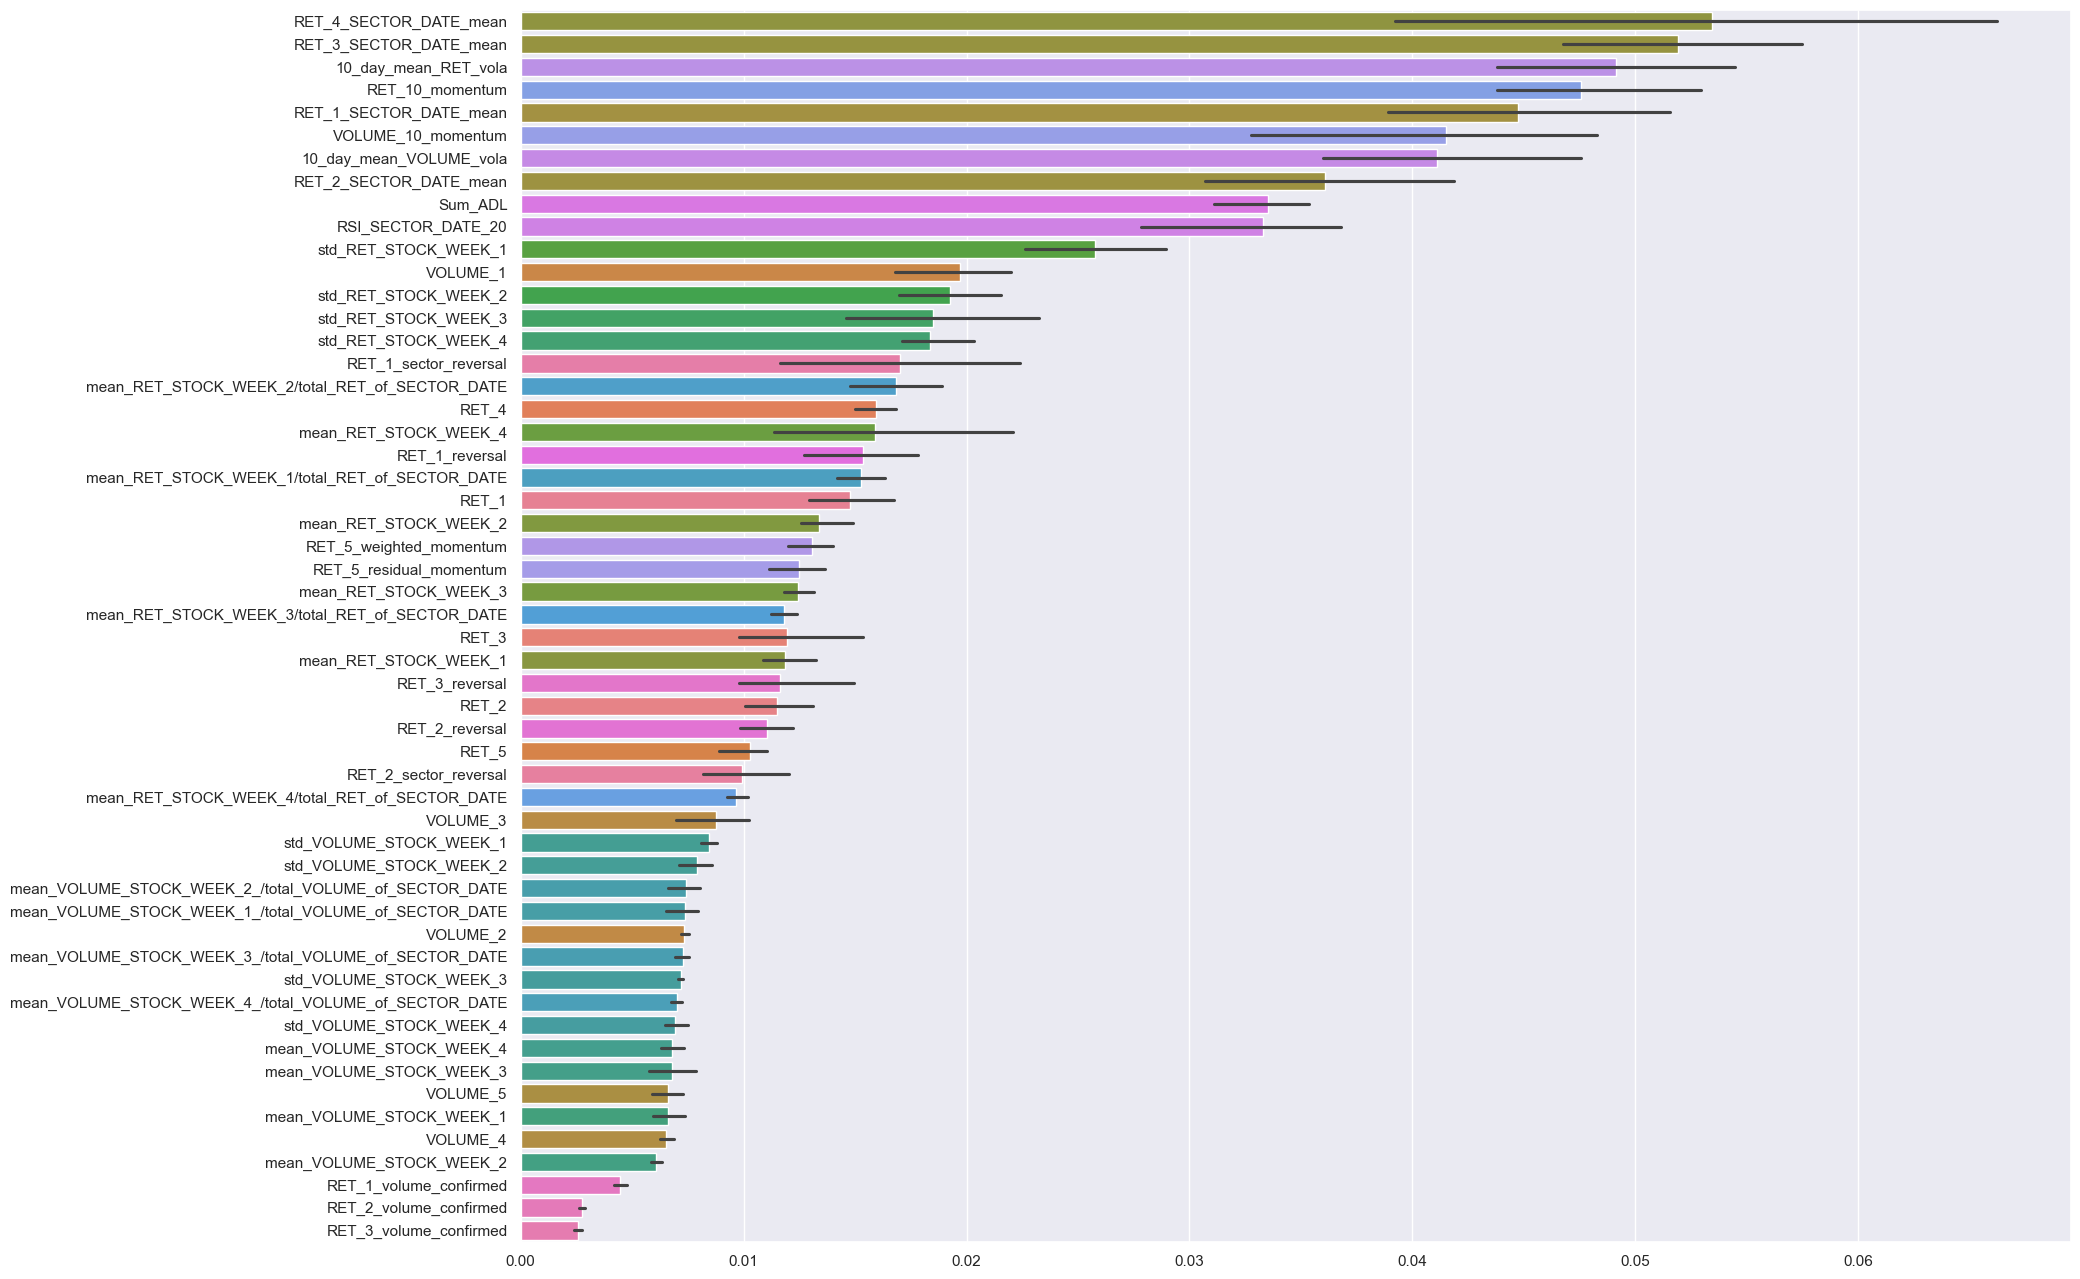

In [460]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.set(rc={'figure.figsize':(20,16)})
sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)

# Prediction

In [461]:
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

target = 'RET'
y_train = train[target]
X_train = train[features]
X_test = test[features]

model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)

# Use diferend decision rules and compare their accuracy
sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
print('median', accuracy_score(y_pred_train,y_train))

sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.mean()).values
print('mean', accuracy_score(y_pred_train,y_train))

print('built-in', accuracy_score(model.predict(X_train),y_train))

y_pred = model.predict_proba(X_test)[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./y_test.csv', index=True, header=True)

median 0.5816414027991612
mean 0.579974491940462
built-in 0.577065804548697


Best submission (median):

In [ ]:
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

target = 'RET'
y_train = train[target]
X_train = train[features]
X_test = test[features]

model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)

sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
print(accuracy_score(y_pred_train,y_train))

y_pred = model.predict_proba(X_test)[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./y_test.csv', index=True, header=True)